# Предсказание наличия частотного диапазона в сигнале
Конечная цель работы — получить бинарный классификатор, способный определить, присутствует ли тот или иной заданный частотный диапазон в звуковом сигнале, используя фичи отфильтрованного под этот диапазон сигнала.  
Начнем с создания функции для генерации и процессинга случайного звукового сигнала `process_audio_signal`, принимающей на вход `f_low` и `f_high` — границы диапазона, наличие которого будем в дальнейшем проверять.  
1. Создаем случайный звуковой сигнал из суммы 3 синусоидальных волн и случайного шума из нормального распределения.
2. Нормализуем значения `f_low` и `f_high`, используя половину частоты дискретизации (частота Найквиста).
3. Применим к сигналу фильтр Баттерворта, удаляя частоты за пределами заданного диапазона
4. С помощью дискретного преобразования Фурье и соответствующих формул, вычислим фичи отфильтрованного сигнала — спектральный центроид и ширину спектра.
5. Возвращаем отфильтрованный сигнал (понадобится для дальнейшей генерации синтетических данных) и его фичи.

In [73]:
import scipy
import numpy as np
from random import randint

def process_audio_signal(f_low: float, f_high: float) -> tuple[np.ndarray, np.ndarray]:

    sampling_rate = 16000
    signal = np.zeros(sampling_rate)
    for sine_wave in range(3):
        fund_freq = randint(100, 400)
        signal += np.sin(2 * np.pi * fund_freq * (np.arange(sampling_rate) / sampling_rate))
    noise = np.random.normal(0, 0.01, sampling_rate)
    signal += noise

    nyquist = 0.5 * sampling_rate
    low = f_low / nyquist
    high = f_high / nyquist

    order = 4
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    filtered_signal = scipy.signal.lfilter(b, a, signal)


    fft = np.abs(np.fft.fft(filtered_signal))
    fft_half = fft[:len(fft) // 2]
    
    central_spectroid = sum(k * fft_half[k] for k in range(len(fft_half))) / sum(fft_half)

    mean_freq = central_spectroid
    spectral_bandwidth = np.sqrt(sum(((k - mean_freq) ** 2) * fft_half[k] for k in range(len(fft_half))) / sum(fft_half))

    return filtered_signal, np.array([central_spectroid, spectral_bandwidth])
    

Сгенерируем синтетические данные, обернем их в датасет-классы из `torch`. Для этого: выберем случайные границы частотного диапазона, вызовем `process_audio_signal` с ними в качестве параметров, проверим на наличие шума (с параметром стандартного отклонения нормального распределения $0.01$ порог 0.05 отсекает шум в более чем $99\%$ случаев), добавим к примерам соответствующего класса ($0$ — частот указанного диапазона в сигнале не было, $1$ — были).

In [45]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Generator
import torch
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

class FrequencyPresence(Dataset):
    def __init__(self, dataset):
        self.features = []
        self.labels = []
        for cls in dataset:
            for sample in dataset[cls]:
                self.features.append(sample)
                labels = [0, 0]
                labels[cls] = 1
                self.labels.append(labels)
        self.features = np.float32(self.features)
        self.labels = torch.Tensor(self.labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def generate_dataset(n_samples : int, f_lower_bound : int, f_upper_bound : int):
    features = {0: [], 1: []}
    for i in range(n_samples):
        f_low = randint(f_lower_bound, f_upper_bound-1)
        f_high = randint(f_low+1, f_upper_bound)
        filtered_signal, sample_features = process_audio_signal(f_low, f_high)
        if np.max(np.abs(filtered_signal)) > 0.05:
            features[1].append(sample_features)
        else:
            features[0].append(sample_features)
        if i%(n_samples//10)==0:
            print(f"{i/(n_samples//100)}%")
    return features
    

Теперь приступим к генерации. Возьмем количество примеров с запасом — потом некоторые нужно будет обрезать, чтобы сбалансировать датасет. Рассмотрим на графике распределение примеров по классам до и после обрезки.

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


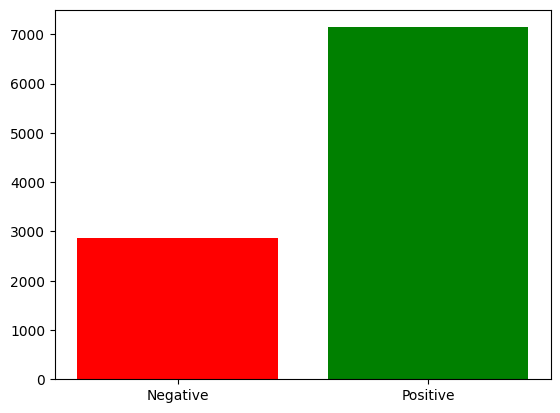

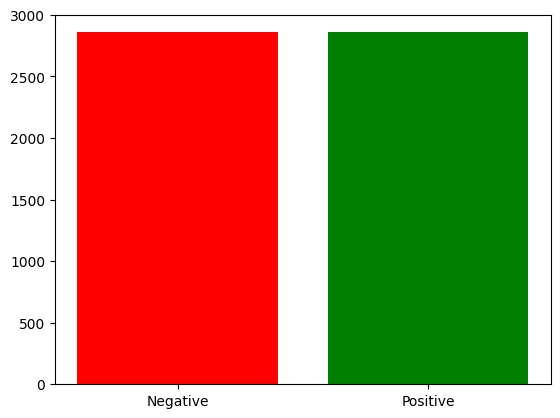

In [43]:
n_samples = 10000
f_lower_bound = 100
f_upper_bound = 1000

dataset = generate_dataset(n_samples, f_lower_bound, f_upper_bound)
sizes = [len(dataset[cls]) for cls in dataset]
plt.bar(["Negative", "Positive"], sizes, color=["red", "green"])
plt.show()
for cls in dataset:
    dataset[cls] = dataset[cls][:min(sizes)]
plt.bar(["Negative", "Positive"], [len(dataset[cls]) for cls in dataset], color=["red", "green"])
plt.show()

Разобьем датасет на тренировочную и тестовую выборки с соотношеним $80/20$, обернем в класс `DataLoader`.

In [46]:
train_ds, test_ds = random_split(FrequencyPresence(dataset), [0.8, 0.2], Generator().manual_seed(42))
train_dl = DataLoader(train_ds, batch_size=128)
test_dl =  DataLoader(test_ds, batch_size=128)

Напишем простейшую полносвязную нейронную сеть для бинарной классификации; установим значение гиперпараметров `learning_rate`, `num_epochs`. Эпох тренировки возьмем с запасом, не помешает ввести раннюю остановку для избежания оверфиттинга модели: скажем, если лосс не падает на протяжении 100 эпох, остановимся.  
<i>P.S. Пока тренировал с разными гиперпараметрами, заметил интересный и странный баг — `Starting epoch #{epoch}` иногда выводится только на каждом втором, а то и только на каждом третьем круге 0_o</i>

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim 

class FreqPresModel(nn.Module):
    def __init__(self):
        super(FreqPresModel, self).__init__()
        self.hdn = nn.Linear(2, 8)
        self.out = nn.Linear(8, 2)

    def forward(self, x):
        x = self.hdn(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        return x

model = FreqPresModel()
loss_fn = nn.CrossEntropyLoss()
lr = 0.005
optim = optim.AdamW(params=model.parameters(), lr=lr)
num_epochs = 1500


patience = 100
curr_corrupted = 0
best_test_loss = 10e5

for epoch in range(1, num_epochs+1):
    print(f"Starting epoch #{epoch}.", end=' ')
    running_loss = 0
    count = 0
    for x,y in train_dl:
        optim.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        running_loss += loss.item()
        count += 1
        optim.step()
    print(f"Training loss: {running_loss/count}.", end=' ')
    running_loss = 0
    count = 0
    for x,y in test_dl:
        output = model(x)
        loss = loss_fn(output, y)
        running_loss += loss.item()
        count += 1
        
    test_loss = running_loss/count
    print(f"Test loss: {test_loss}")
    if test_loss > best_test_loss:
        curr_corrupted += 1
    else:
        curr_corrupted = 0
        best_test_loss = test_loss
    if patience<=curr_corrupted:
        print("Early stopping due to overfitting.")
        break    
        

Starting epoch #1. Training loss: 56.91116441620721. Test loss: 17.54939556121826
Training loss: 11.836705909834969. Test loss: 6.665974722968207
Starting epoch #3. Training loss: 3.021365868548552. Test loss: 0.9304450220531888
Training loss: 0.6813902209202448. Test loss: 0.54041478700108
Starting epoch #5. Training loss: 0.5522744754950205. Test loss: 0.49498167965147233
Training loss: 0.5225196480751038. Test loss: 0.4864025115966797
Starting epoch #7. Training loss: 0.5212339121434424. Test loss: 0.4844996862941318
Test loss: 0.47281210952334934ss: 0.5196616335047616. 
Starting epoch #9. Training loss: 0.5097311130828328. Test loss: 0.4522164265314738
Training loss: 0.49409298681550556. Test loss: 0.45708518226941425
Starting epoch #11. Training loss: 0.4841604150003857. Test loss: 0.4558711018827226
Training loss: 0.48045623385243946. Test loss: 0.4541509681277805
Starting epoch #13. Training loss: 0.4774000942707062. Test loss: 0.4531283544169532
Training loss: 0.474363686309920

Классификатор натренировали, можем смотреть на результат. Спарсим тестовую выборку в более удобный формат, проведем инференс и воспользуемся встроенными в `sklearn` замерениями метрик. Для начала глянем на `classification_report`, предоставляющий значения метрик `recall, precision` и так далее; также визуализируем confusion matrix.

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       567
           1       0.84      0.85      0.84       576

    accuracy                           0.84      1143
   macro avg       0.84      0.84      0.84      1143
weighted avg       0.84      0.84      0.84      1143



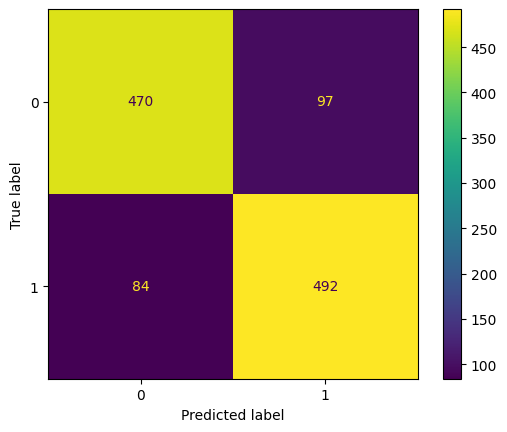

In [70]:
test_labels = []
test_samples = []

for x,y in test_ds:
    test_labels.append(y)
    test_samples.append(x)

with torch.no_grad():
    y_pred = [i.argmax().item() for i in model(torch.Tensor(test_samples))]
    
y_real = [i.argmax().item() for i in test_labels]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred)).plot()
print(classification_report(y_real, y_pred))

# Выводы
Даже с такой простой архитектурой классификатор показывает весьма достойный результат. Таким образом, можем проследить весьма явную зависимость между такими фичами отфильтрованного сигнала, как спектральный центроид (центр масс спектра частот) и ширина спектра (область частот, содержащая основную часть энергии сигнала), и фактом наличия в изначальном сигнале диапазона частот, которым задан фильтр.  
Весьма интересным кажется количество локальных минимумов лосс-функции для этой задачи классификации: много раз модель ловила минимум на тестовой выборке — причем, весьма плохой — на самой первой эпохе, и дальше лишь оверфиттилась: так что тренировочный процесс особо чувствителен к значениям гиперпараметров `learning_rate` и `num_epochs`. 